In [13]:

import torch
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from datasetUtils import load_from_Jadson
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


#carregando labels

labels_teste = np.load("resultados/labels_test.npy", allow_pickle=True).astype(int)
labels_validation = np.load("resultados/labels_validation.npy", allow_pickle=True).astype(int)

print("tamanho de labels_teste: " + str(len(labels_teste)))
print("tamanho de labels_validation: " + str(len(labels_validation)))
#corregando dados

features_teste = torch.load("resultados/test.pt")
features_validation = torch.load("resultados/validation.pt")

print("tamanho de features_teste: " + str(features_teste.size()))
print("tamanho de features_validation: " + str(features_validation.size()))


tamanho de labels_teste: 24000
tamanho de labels_validation: 9600
tamanho de features_teste: torch.Size([24000, 2048])
tamanho de features_validation: torch.Size([9600, 2048])


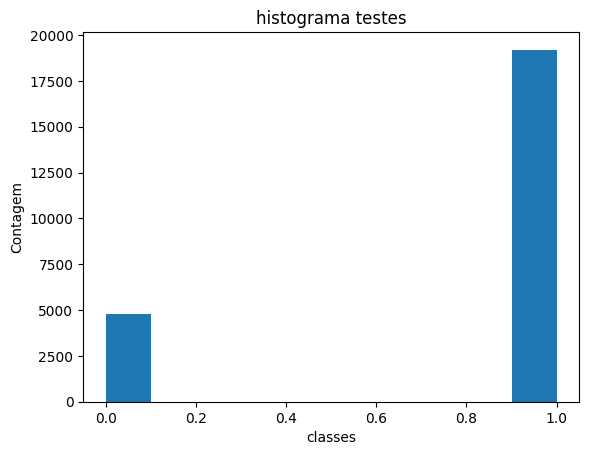

In [14]:

data = labels_teste
plt.hist(data)
plt.title("histograma testes")
plt.xlabel("classes")
plt.ylabel("Contagem")
plt.show()


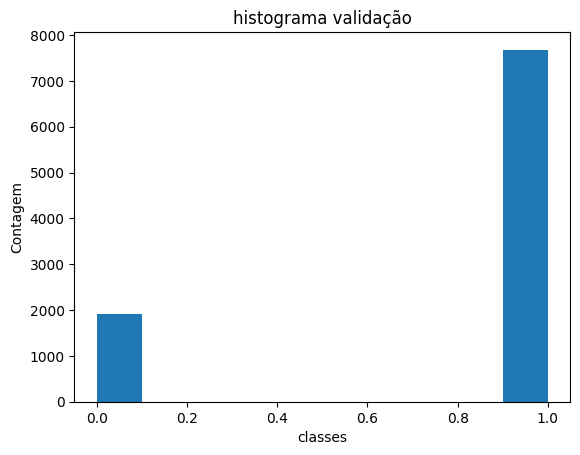

In [15]:

data = labels_validation
plt.hist(data)
plt.title("histograma validação")
plt.xlabel("classes")
plt.ylabel("Contagem")
plt.show()


/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


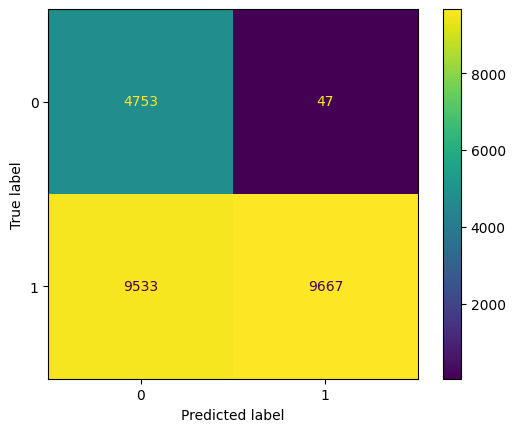

[1 1 1 ... 0 0 0]
[1 1 1 ... 0 0 0]
Acurácia: 0.6008333333333333
Precisão: 0.9951616224006589
Recall: 0.5034895833333334
F1-Score: 0.6686726153420489


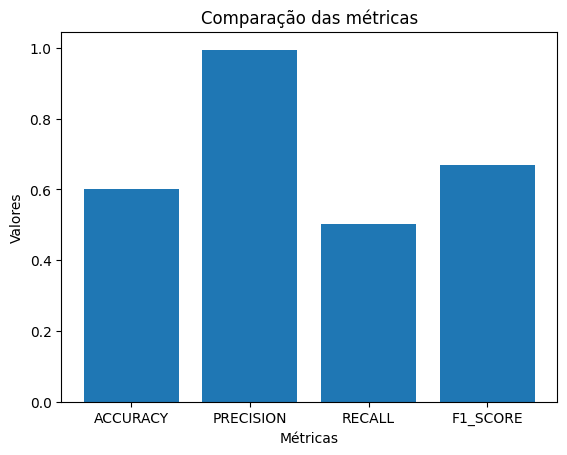

/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


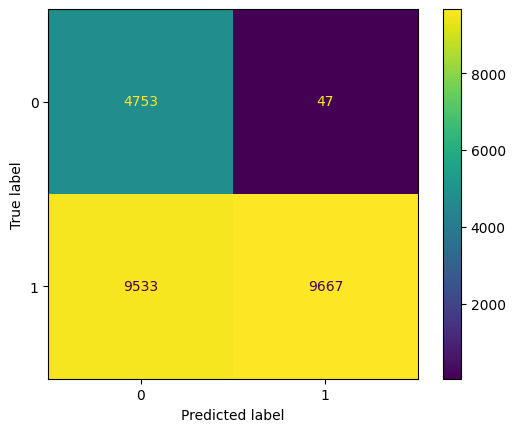

[1 1 1 ... 0 0 0]
[1 1 1 ... 0 0 0]
Acurácia: 0.6008333333333333
Precisão: 0.9951616224006589
Recall: 0.5034895833333334
F1-Score: 0.6686726153420489


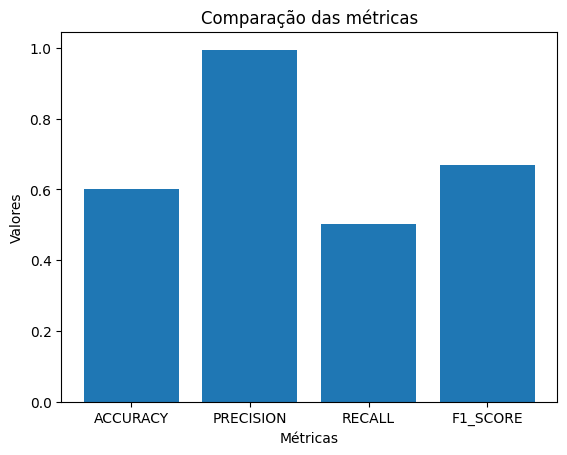

/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


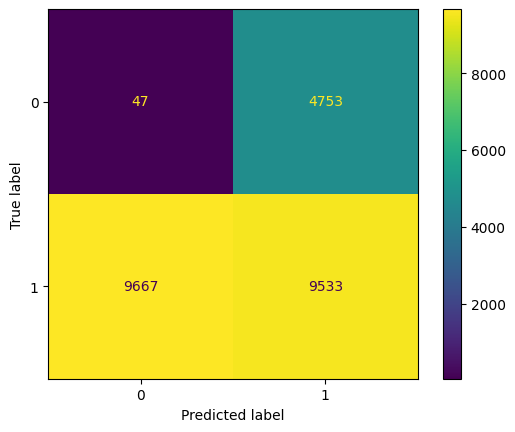

[1 1 1 ... 0 0 0]
[0 0 0 ... 1 1 1]
Acurácia: 0.39916666666666667
Precisão: 0.6672966540669186
Recall: 0.4965104166666667
F1-Score: 0.569372274980589


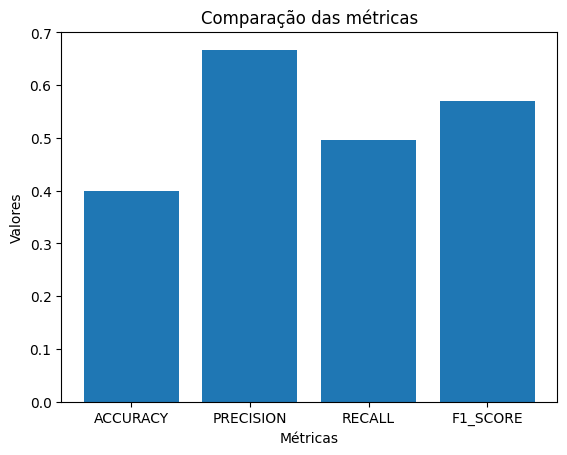

/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


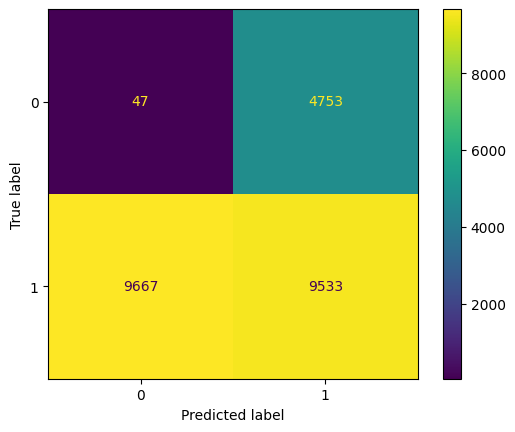

[1 1 1 ... 0 0 0]
[0 0 0 ... 1 1 1]
Acurácia: 0.39916666666666667
Precisão: 0.6672966540669186
Recall: 0.4965104166666667
F1-Score: 0.569372274980589


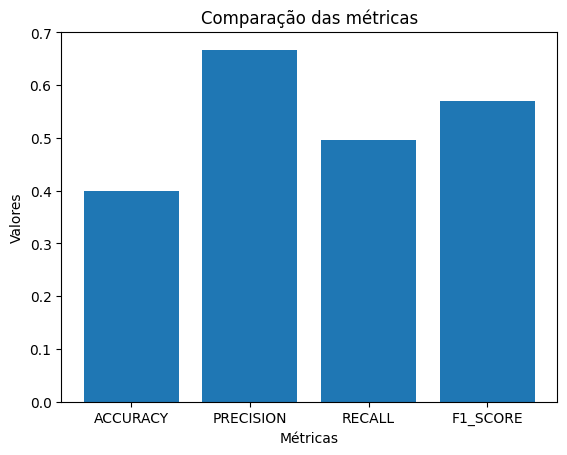

/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


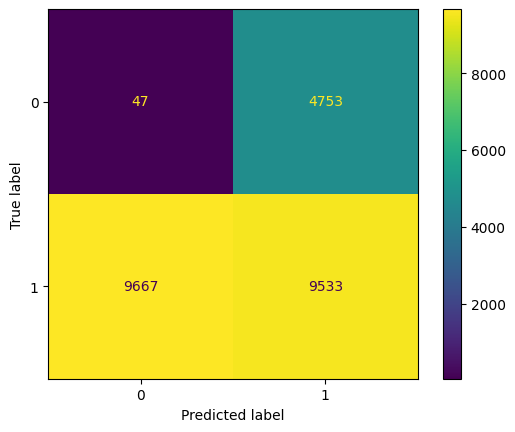

[1 1 1 ... 0 0 0]
[0 0 0 ... 1 1 1]
Acurácia: 0.39916666666666667
Precisão: 0.6672966540669186
Recall: 0.4965104166666667
F1-Score: 0.569372274980589


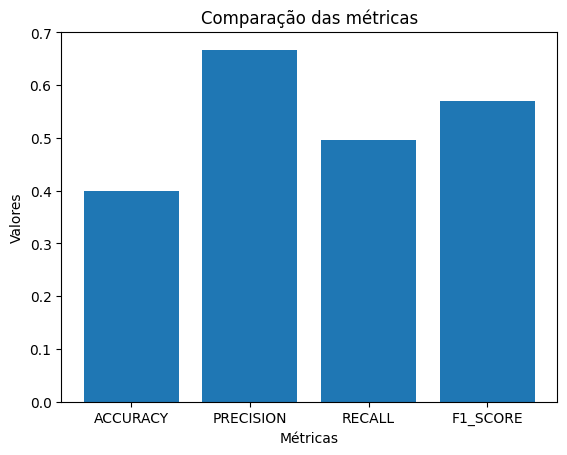

/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


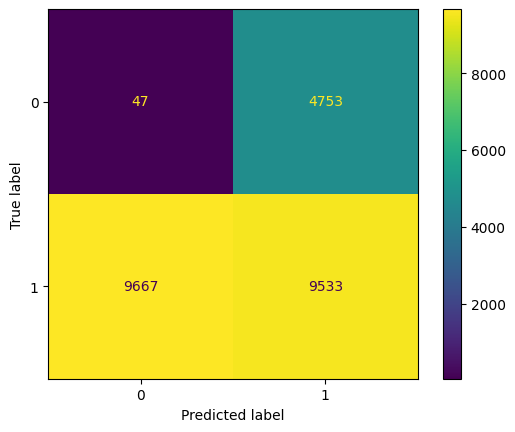

[1 1 1 ... 0 0 0]
[0 0 0 ... 1 1 1]
Acurácia: 0.39916666666666667
Precisão: 0.6672966540669186
Recall: 0.4965104166666667
F1-Score: 0.569372274980589


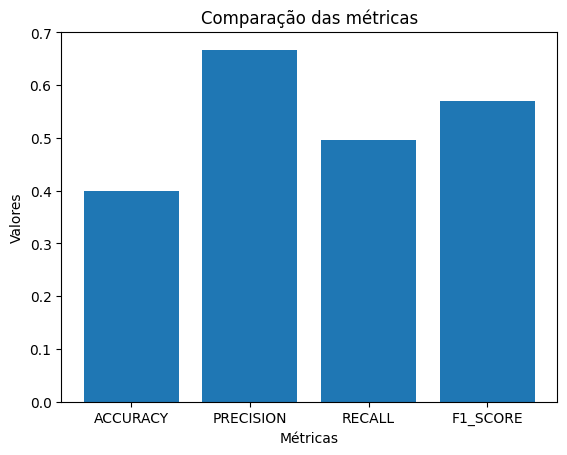

/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


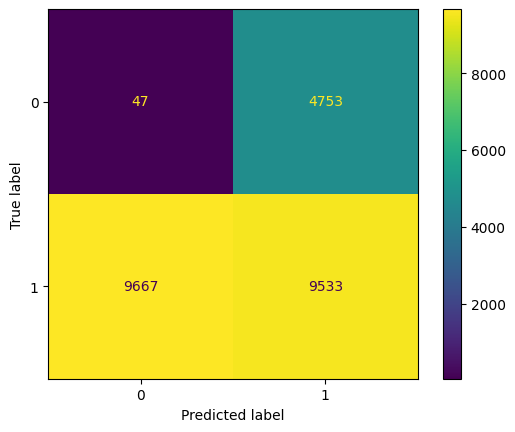

[1 1 1 ... 0 0 0]
[0 0 0 ... 1 1 1]
Acurácia: 0.39916666666666667
Precisão: 0.6672966540669186
Recall: 0.4965104166666667
F1-Score: 0.569372274980589


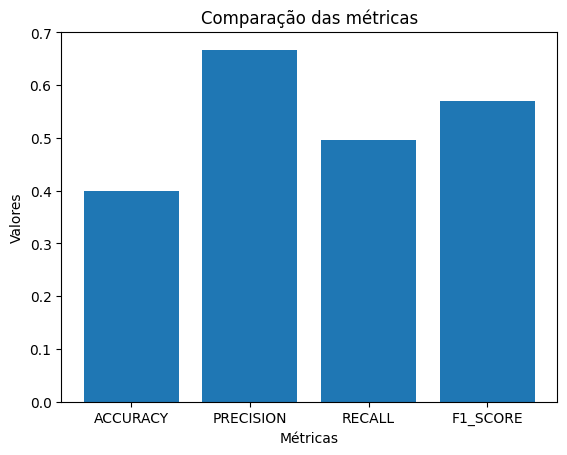

/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


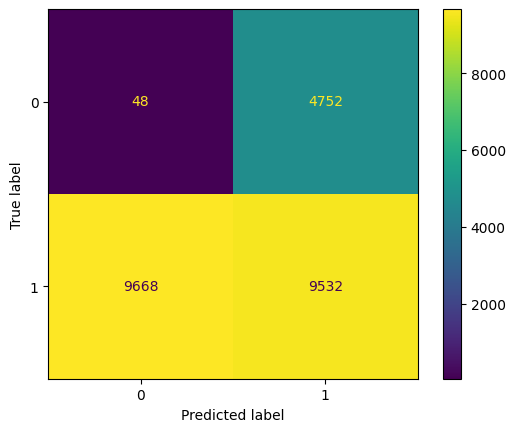

[1 1 1 ... 0 0 0]
[0 0 0 ... 1 1 1]
Acurácia: 0.39916666666666667
Precisão: 0.6673200784094091
Recall: 0.49645833333333333
F1-Score: 0.5693465535778283


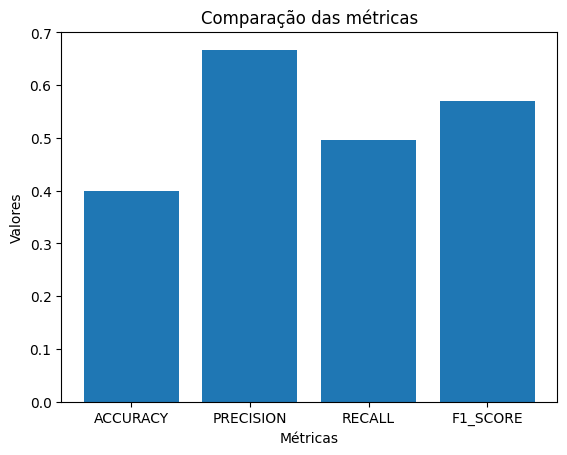

/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


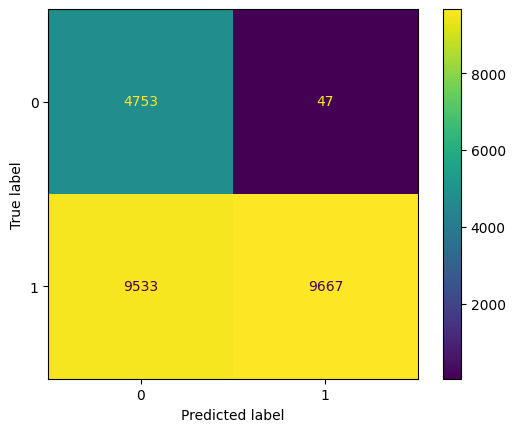

[1 1 1 ... 0 0 0]
[1 1 1 ... 0 0 0]
Acurácia: 0.6008333333333333
Precisão: 0.9951616224006589
Recall: 0.5034895833333334
F1-Score: 0.6686726153420489


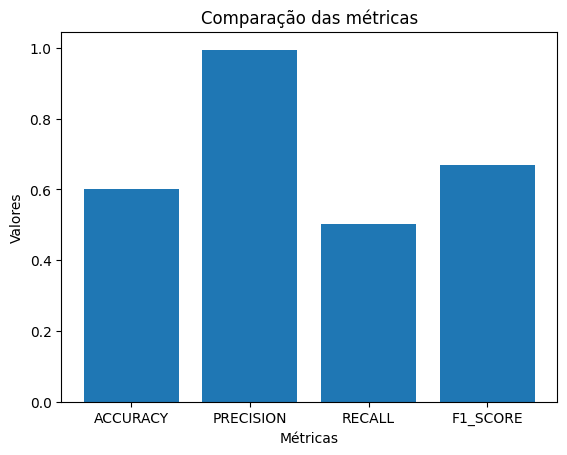

/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


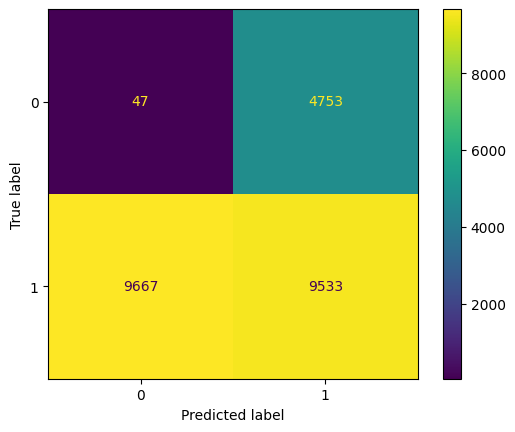

[1 1 1 ... 0 0 0]
[0 0 0 ... 1 1 1]
Acurácia: 0.39916666666666667
Precisão: 0.6672966540669186
Recall: 0.4965104166666667
F1-Score: 0.569372274980589


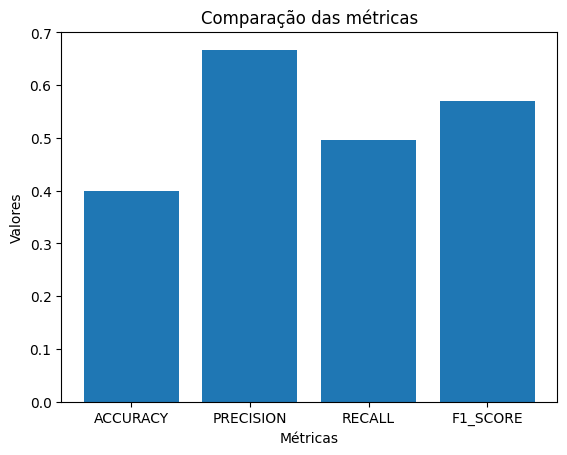

[[0.60083333 0.99516162 0.50348958 0.66867262]
 [0.60083333 0.99516162 0.50348958 0.66867262]
 [0.39916667 0.66729665 0.49651042 0.56937227]
 [0.39916667 0.66729665 0.49651042 0.56937227]
 [0.39916667 0.66729665 0.49651042 0.56937227]
 [0.39916667 0.66729665 0.49651042 0.56937227]
 [0.39916667 0.66729665 0.49651042 0.56937227]
 [0.39916667 0.66732008 0.49645833 0.56934655]
 [0.60083333 0.99516162 0.50348958 0.66867262]
 [0.39916667 0.66729665 0.49651042 0.56937227]]


/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


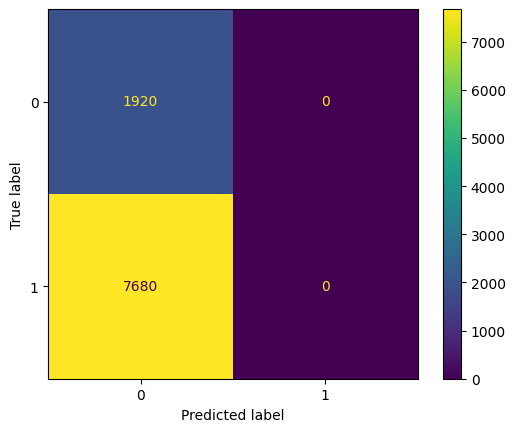

/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[1 1 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
Acurácia: 0.2
Precisão: 0.0
Recall: 0.0
F1-Score: 0.0


/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


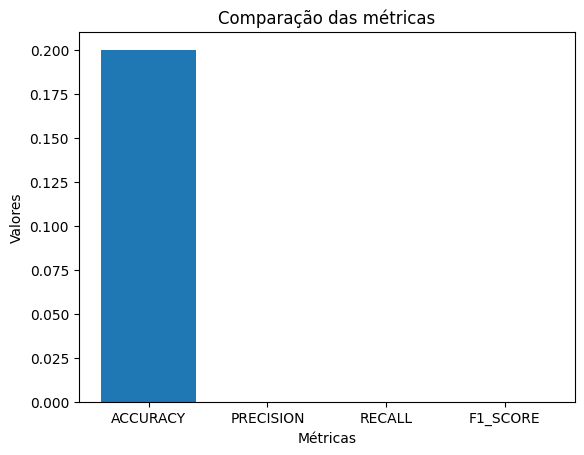

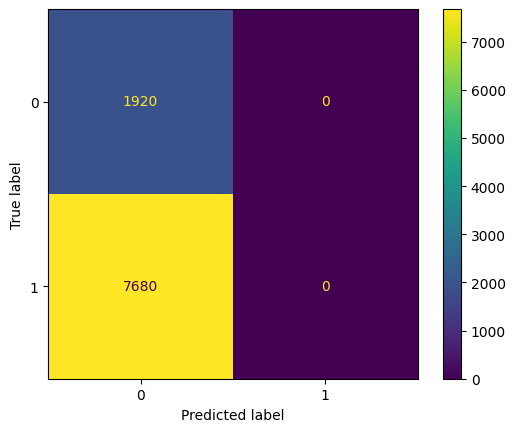

/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[1 1 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
Acurácia: 0.2
Precisão: 0.0
Recall: 0.0
F1-Score: 0.0


/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


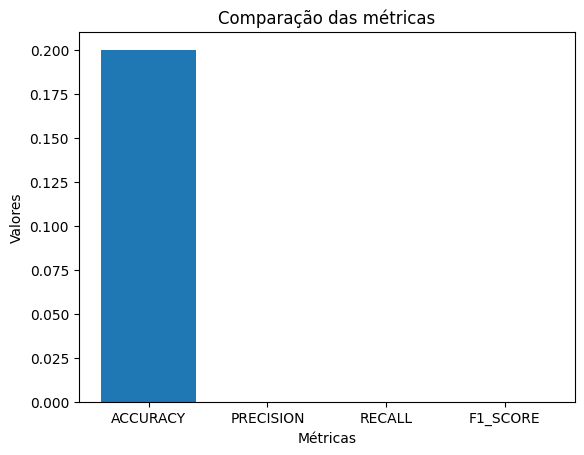

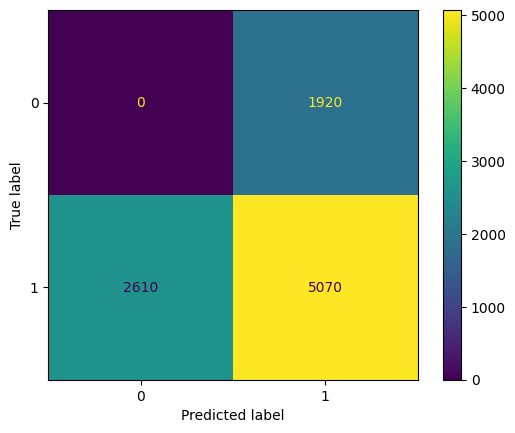

[1 1 1 ... 0 0 0]
[1 1 1 ... 1 1 1]
Acurácia: 0.528125
Precisão: 0.7253218884120172
Recall: 0.66015625
F1-Score: 0.6912065439672802


/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


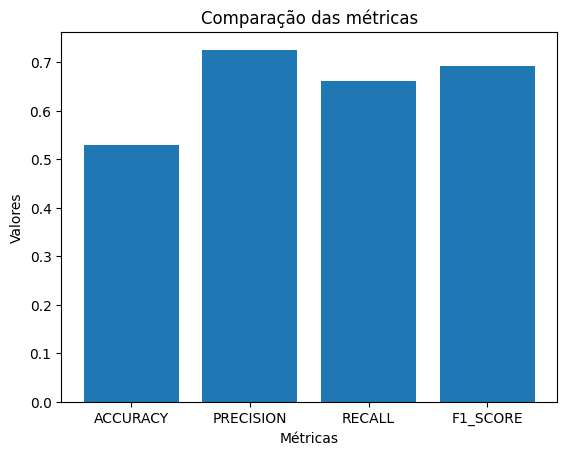

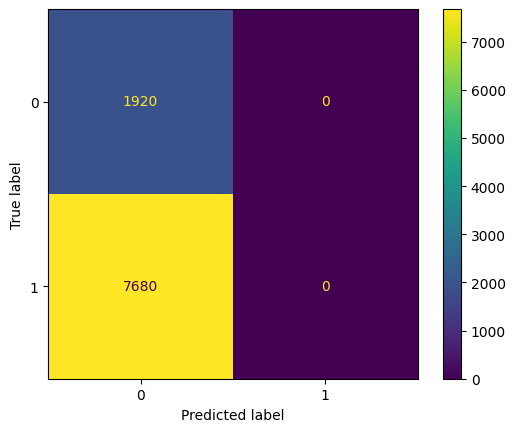

/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[1 1 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
Acurácia: 0.2
Precisão: 0.0
Recall: 0.0
F1-Score: 0.0


/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


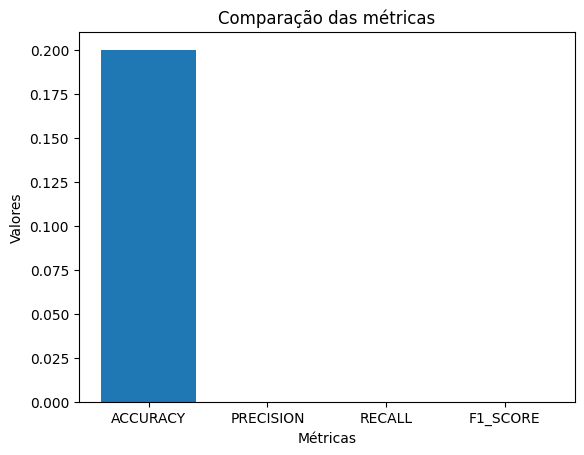

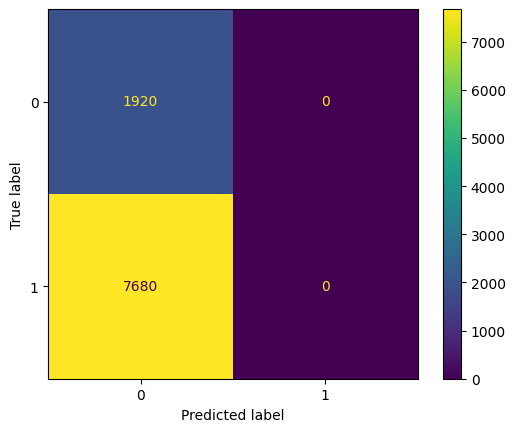

/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[1 1 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
Acurácia: 0.2
Precisão: 0.0
Recall: 0.0
F1-Score: 0.0


/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


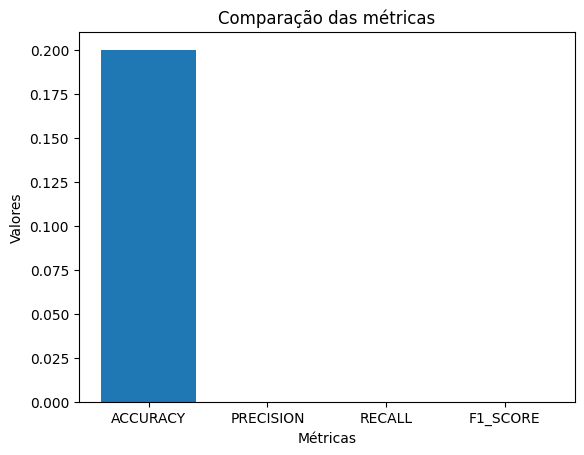

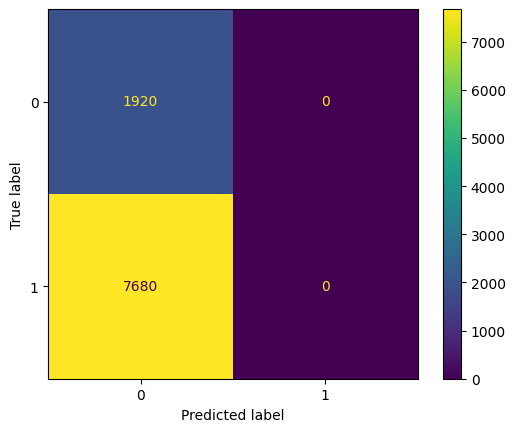

/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[1 1 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
Acurácia: 0.2
Precisão: 0.0
Recall: 0.0
F1-Score: 0.0


/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


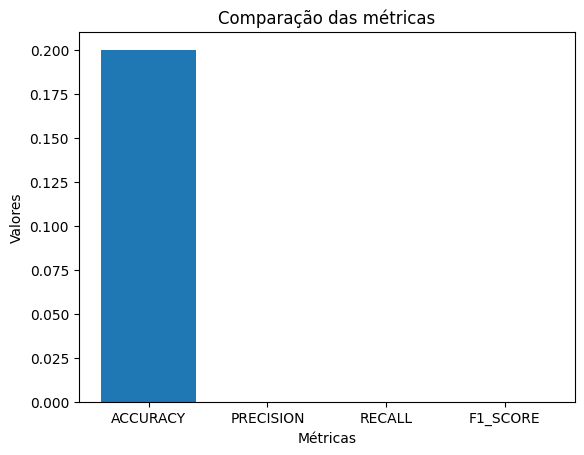

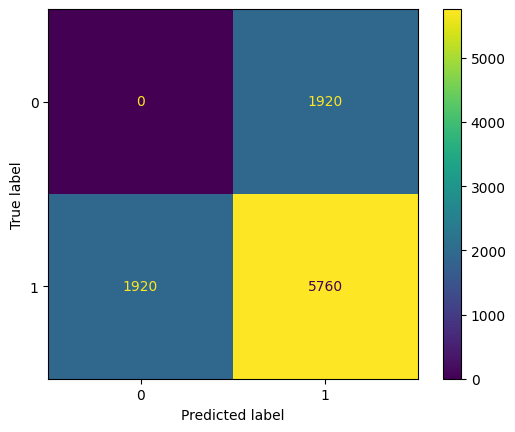

[1 1 1 ... 0 0 0]
[1 1 1 ... 1 1 1]
Acurácia: 0.6
Precisão: 0.75
Recall: 0.75
F1-Score: 0.75


/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


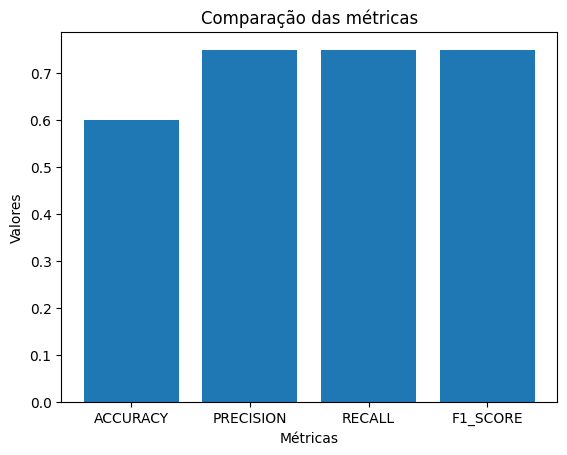

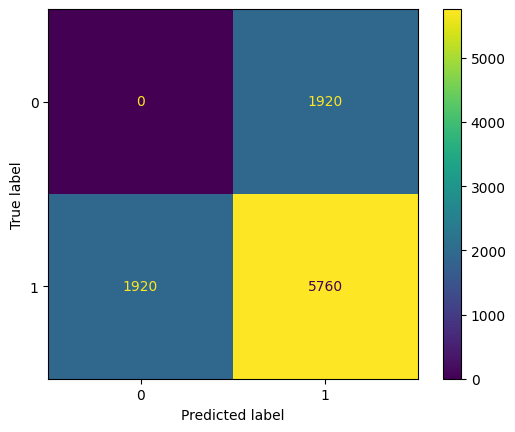

[1 1 1 ... 0 0 0]
[1 1 1 ... 1 1 1]
Acurácia: 0.6
Precisão: 0.75
Recall: 0.75
F1-Score: 0.75


/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


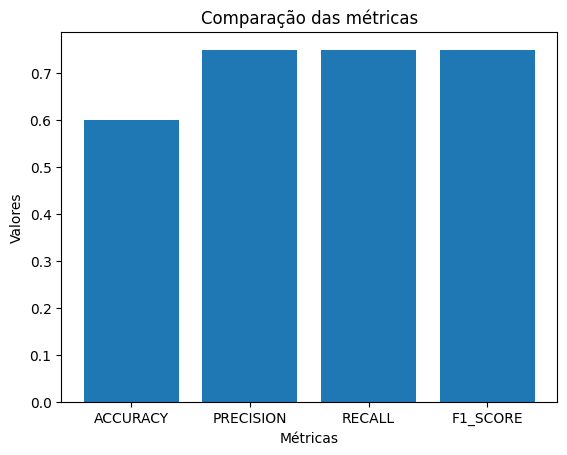

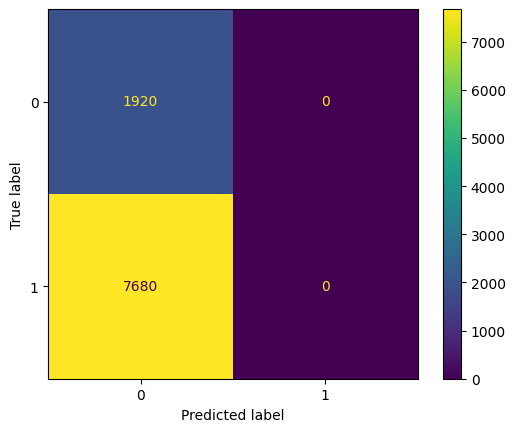

/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[1 1 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
Acurácia: 0.2
Precisão: 0.0
Recall: 0.0
F1-Score: 0.0


/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


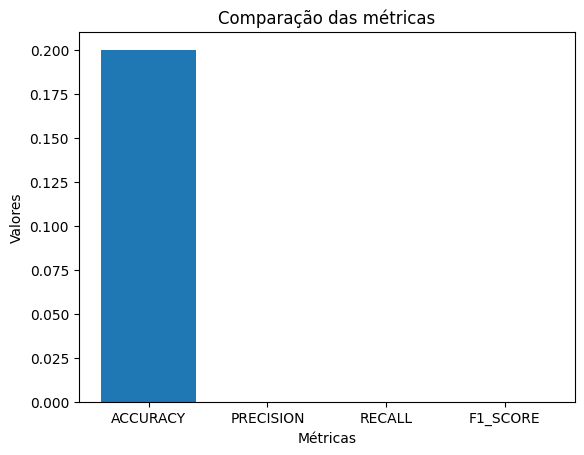

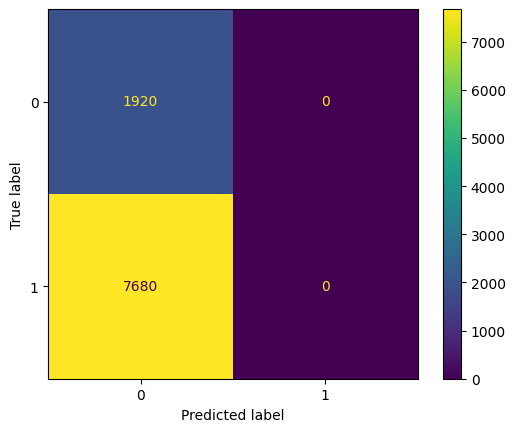

[1 1 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
Acurácia: 0.2
Precisão: 0.0
Recall: 0.0
F1-Score: 0.0
[[0.2        0.         0.         0.        ]
 [0.2        0.         0.         0.        ]
 [0.528125   0.72532189 0.66015625 0.69120654]
 [0.2        0.         0.         0.        ]
 [0.2        0.         0.         0.        ]
 [0.2        0.         0.         0.        ]
 [0.6        0.75       0.75       0.75      ]
 [0.6        0.75       0.75       0.75      ]
 [0.2        0.         0.         0.        ]
 [0.2        0.         0.         0.        ]]


/home/emorais/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


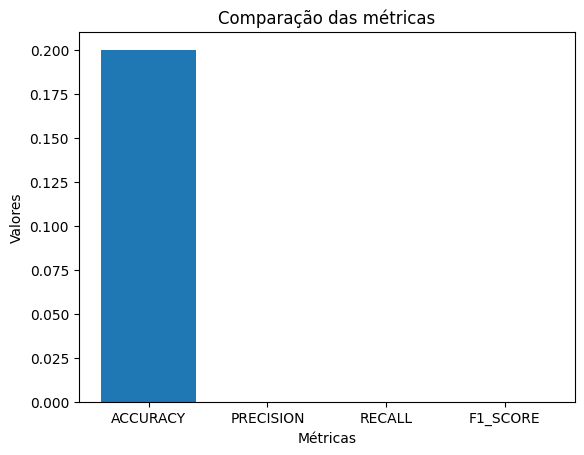

In [16]:

base_name_dir = "/hadatasets/Synthetic-Realities/20-spoofing-mpad/2020-plosone-recod-mpad"

def calc_predito(clusters, features, labels_ground_truth):
    
    kmeans = KMeans(n_clusters=clusters)
    kmeans.fit(features)
    labels_kmt = kmeans.labels_

    predito = np.zeros(len(labels_ground_truth), dtype=int)
    #for k in range(clusters):
    zero_idx = np.where(labels_kmt==0)[0]
    one_idx  = np.where(labels_kmt==1)[0]
    GT_zero = labels_ground_truth[zero_idx]
    labels,frequecia = np.unique(GT_zero, return_counts=True)
    #print(k,labels,frequecia)
        
    if len(labels)==2 :
        if frequecia[0] > frequecia[1] : 
            predito[zero_idx] = labels[0]
            predito[one_idx]  = labels[1]
            
        else: 
            predito[zero_idx] = labels[1]
            predito[one_idx]  = labels[0]
               
        # contagem = np.zeros(clusters, dtype=int)
        # # para cada i em labels_kmt
        # # for indice, (el1,el2) in enumerate(zip(labels_kmt, labels_ground_truth)):
        # for indice, (el1,el2) in (zip(labels_kmt, labels_ground_truth)):
        #     if el1 == k: 
        #         contagem[el2] +=1
        # max = np.argmax(contagem)
        # 
        # for indice, (el1,el2) in enumerate(zip(labels_kmt, labels_ground_truth)):
        #     if el1 == k:
        #         predito[indice] = max
                
    return predito 

def medidas(GT, predito):
    y_true = GT
    y_pred = predito
    confusion = confusion_matrix(GT, predito)
    
    
    disp = ConfusionMatrixDisplay(confusion)
    disp.plot()
    plt.show()

    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    # calculando as métricas iniciais
    # # Calcular a acurácia (Accuracy)
    accuracy = accuracy_score(y_true, y_pred)
    
    
    # Calcular a precisão (Precision)
    precision = precision_score(y_true, y_pred)
    
    # Calcular o recall (Sensibilidade)
    recall = recall_score(y_true, y_pred)
     
    # Calcular o F1-Score
    f1_score = f1_score(y_true, y_pred)
    
    TP = confusion[0,0]
    FN = confusion[0,1]
    FP = confusion[1,0]
    TN = confusion[1,1]
    
    # # Calcular o APCER
    # APCER = FN / (TP + FN)
         
    # # Calcular o BPCER
    # BPCER = FP / (TN + FP)
    
    return [accuracy, precision, recall, f1_score], ['ACCURACY', 'PRECISION', 'RECALL', 'F1_SCORE'] #incluir APCER e BPCER
    
def desenha_metricas(GT, features, labels_ground_truth, show_all=True):
        
    predito = calc_predito(clusters=2,features=features,labels_ground_truth=labels_ground_truth)
    metricas, rotulos = medidas(GT=GT,predito=predito)
    
    print(GT)
    print(predito)

    accuracy  = metricas[0]
    precision = metricas[1]
    recall    = metricas[2]
    f1_score  = metricas[3]
    #APCER     = metricas[4]
    #BPCER     = metricas[5]


    print(f'Acurácia: {accuracy}')
    print(f'Precisão: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-Score: {f1_score}')
    # print(f'APCER: {APCER}')
    # print(f'BPCER: {BPCER}') 

    # Criar o gráfico de barras
    plt.bar(rotulos, metricas)

    # Adicionar rótulos e título
    plt.xlabel("Métricas")
    plt.ylabel("Valores")
    plt.title("Comparação das métricas")

    # Exibir o gráfico
    if (show_all == True):
        plt.show()
    
    return rotulos, metricas

GT = load_from_Jadson("csvs/test_motog5.csv", base_name_dir)
GT = np.array([ int(item[1]) for item in GT])

metricas_t = []
for i in range(10):
    rotulos_t, metricas = desenha_metricas(GT=GT, features=features_teste, labels_ground_truth=labels_teste)
    metricas_t.append(metricas)
metricas_t = np.array(metricas_t)
print(metricas_t)

GT = load_from_Jadson("csvs/val_motog5.csv", base_name_dir)
GT = np.array([ int(item[1]) for item in GT])
metricas_v = []
for i in range(10):
    rotulos_v, metricas = desenha_metricas(GT=GT, features=features_validation, labels_ground_truth=labels_validation, show_all=False)
    metricas_v.append(metricas)
metricas_v = np.array(metricas_v)
print(metricas_v)

